# Imports 🦄

In [50]:
# imports bla bla bla
import sklearn
import skfuzzy as fuzz
import numpy as np
import pandas as pd
from sklearn.datasets import *
import matplotlib.pyplot as plt
import math

# Classic sample export
from sklearn.preprocessing import MinMaxScaler

# classic https://www.kaggle.com/datasets/unsdsn/world-happiness
# Data from kaggle
df = pd.read_csv("2019.csv") 

# Functions

## Normalization and data preprocessing

In [51]:
# Normalization of your data
# now everything will be set in a range of 0 to 1

def splitLastColumn(x):
  """ Returns two numpy vector corresponding to x and y. Splits last columns, and y is transformed to column to row shape.
      [x1,x2,x3,x4,y] -> [x1,x2,x3,x4] [y]    
  """
  # the [:end] will not take the end number position in count
  end = x.shape[1]-1
  y = x[:,end:]
  return (np.array(x[:,:end]),np.array(y).flatten())

def normalize_data(x):
    """ Appling minmax normalization on the y axis sample = [x1,x2,x3,x4]"""
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler

## Scikit Fuzzy Functions (equivalent to using the paper one)

In [52]:
# Generate an arrays with a 3 element list for each k partition
# with the values of a triangular shape functions like
# [begining, peak value, ending] 
def k_partitions(k: int, min: int, max: int) -> np.ndarray:
  """  Generate an arrays with a 3 element list for each k partition with the values of a triangular shape functions like
       [begining, peak value, ending] points """
  spaces = []
  portion = (max-min)/(k-1)
  counter = 0
  for i in range(k):
    if(i==0): # first triangle is just half of it
      spaces.append([min,min, min + portion])
      counter = min + portion
    else:
      if(i==(k-1)): # last triangle is just half of it
        spaces.append([max-portion,max, max])
      else: # General cases
        spaces.append([counter-portion,counter,counter+portion])
        counter=counter+portion
  return np.array(spaces)


def fuzz_membership(x: np.ndarray, k: np.ndarray):
    """ For each feature returns k vectors  with the value of membership"""
    output = []
    for i in range(len(x)):
        sample = []
        for j in range(len(k)):
            spaces = k_partitions(k[j], 0, 1)
            belong = []
            for s in spaces:
                if len(k)==1:
                    belong.append(fuzz.trimf(np.array([x[i]]), s))
                else:
                    belong.append(fuzz.trimf(np.array([x[i][j]]), s))
                sample.append(belong)
        output.append(sample)
    return output

## Fuzzy functions

In [63]:
def mu(x,j,k) -> np.ndarray:
  a = (j - 1)/(k-1)
  b = 1/(k-1)
  value = 1 - abs(x-a)/b
  if value <=0:
    return 0
  else:
    return value


# For each feature you will have a k lenght vector with the 
# membership degree of that place.
def membership_for_all_features(x: np.ndarray, k:np.ndarray):
  """For each feature you will have a k lenght vector with the membership degree of that place."""
  output = []
  n_features = len(k)
  for sample in range(len(x)):
    membership_i = []
    # for every feature in the sample
    i = 0
    for f in range(n_features):
      tmp=[]
      # for every subspace of that feature
      for j in range(k[i]):
        if n_features == 1:
          tmp.append(mu(x[sample],j+1,k[i]))
        else:
          tmp.append(mu(x[sample][f],j+1,k[i]))
      # check for the next k_i
      i+=1
      membership_i.append(tmp)
    # when you finish to append you will get the membership of every characteristic of that sample  
    output.append(membership_i)
  return output

#####IMPORTANT CHANGE THIS TO BE DINAMIC
# Here we just generate all posible combinations for all the feature k_i
def combinations_for_k(k:np.ndarray):
  """ Here we just generate all posible combinations for all the feature k_i 
      for example k = [2,2] will return
      [[1,1],[1,2],[2,1],[2,2]]
  """
  output = []
  labels = len(k)
  ### Change this
  if len(k)==3:
    for j in range(k[0]):
      for r in range(k[1]):
        for m in range(k[2]):
          output.append([j,r,m])
    return output
  if len(k)==2:
    for j in range(k[0]):
      for r in range(k[1]):
        output.append([j,r])
    return output
  else:
    for j in range(k[0]):
      output.append([j])
    return output

# now we need to compute every degree of compatibility with every combination
# we will have k_1*k2*...K_n diferent combinations
# if one sample is provided use [[0,3  0,2  0,3]]
def degree_of_compatibility(membership_values, combinations):
  output = []
  n_features = len(combinations[0])
  n_samples = len(membership_values)

  for i in range(n_samples):
    general = []
    for c in combinations:
      tmp = []
      for j in range(n_features):
        tmp.append(membership_values[i][j][c[j]])
      tmp=np.array(tmp)
      general.append(np.product(tmp))
    output.append(general)
  return output

# calculating all combinations for W
def Wj1_jn(dc,k:np.ndarray, alpha=1):
    return np.power(dc,alpha)

# Now we need to compute bj1..jn, we will get a vector with the number of combinations
# posible
# Fuck x2
def bj1_jn(w, y_real):
  output = []
  n_samples=len(w)
  for j in range(len(w[0])):# these are the number of combinations we have
    numerator = [] 
    denominator = []
    for i in range(n_samples):
      numerator.append(w[i][j]*y_real[i])
      denominator.append(w[i][j])
    numerator=np.array(numerator)
    denominator=np.array(denominator)
    #print(denominator)
    value = np.sum(numerator)/np.sum(denominator)
    output.append(value)
  return output

#y(x_p)
def prediction(dc,b,w):
    output = []
    n_samples=len(w)
  
    # change samples
    for i in range(n_samples):
        numerator = [] 
        denominator = []

        for j in range(len(w[0])):# these are the number of combinations we have
            numerator.append(dc[i][j]*b[j])
            denominator.append(dc[i][j])

        numerator=np.array(numerator)
        denominator=np.array(denominator)
        #print(denominator)
        value = np.sum(numerator)/np.sum(denominator)
        output.append(value)
    return output

# Review Two features

In [64]:
# [x1,x2...xn,y]
#c = ['Social support', 'GDP per capita','Freedom to make life choices','Score']
c = ['Social support', 'GDP per capita','Score']
data = df[c].to_numpy()

#### Check this normalization

data_scaled,_ = normalize_data(data)

####
x, y = splitLastColumn(data_scaled)
####

# For each sample I will have a 2 arrays with k_i values in them, to specify the 
# memebership values on each sub space

k=np.array([3,3])

print('shape of x values ->', x.shape)

# array with the shape of features and his dimensional
membership_values = membership_for_all_features(x,k)

# Printing values for debug
#print(np.array(membership_values).shape)
#print(membership_values[0])

# Now we will generate an array with the combinations of subspaces
# that our fuzzynes needs.
# this will be the subspaces we will check on each value space
combinations = combinations_for_k(k)
combinations

# all combinations possible for the degree of compatibility for each sample
dc = degree_of_compatibility(membership_values, combinations)
print("Shape of the degree of compatibility vector (samples, combinations) ->",np.array(dc).shape)


w = Wj1_jn(dc,k,alpha=0.5)
print("Shape of W, should be same as dc ->",np.array(dc).shape)

b = bj1_jn(w,y)
print("Shape of b ->",np.array(dc).shape)

y_p = prediction(dc,b,w)

PI = []
for i in range(len(y)):
  a = (y_p[i]-y[i])**2
  PI.append(a/2)
  #print(f'predicted {y_p[i]} - real {y[i]}')
PI=np.array(PI)
print("accuracy = ", np.sum(PI) )


shape of x values -> (156, 2)
Shape of the degree of compatibility vector (samples, combinations) -> (156, 9)
0.5
Shape of W, should be same as dc -> (156, 9)
Shape of b -> (156, 9)
accuracy =  1.7675670593601596


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
0.1


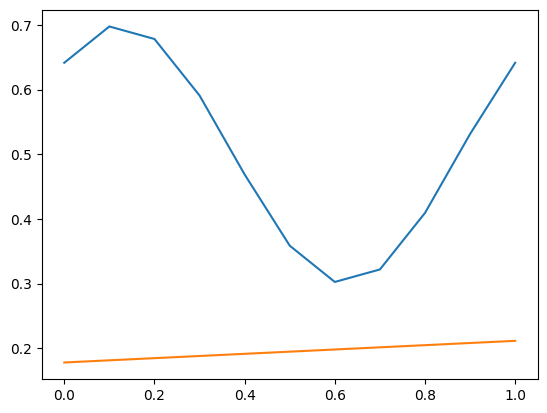

0.1


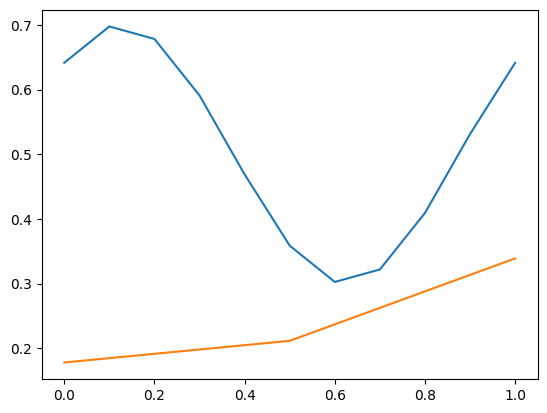

0.1


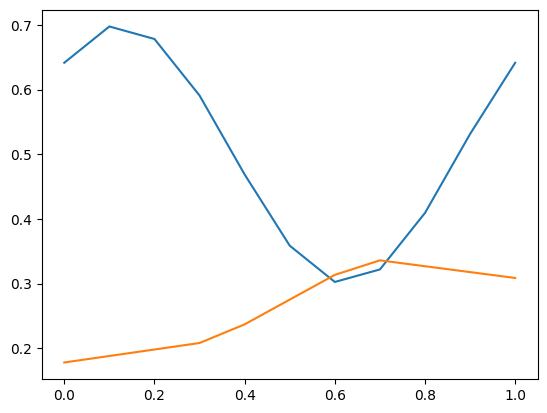

0.1


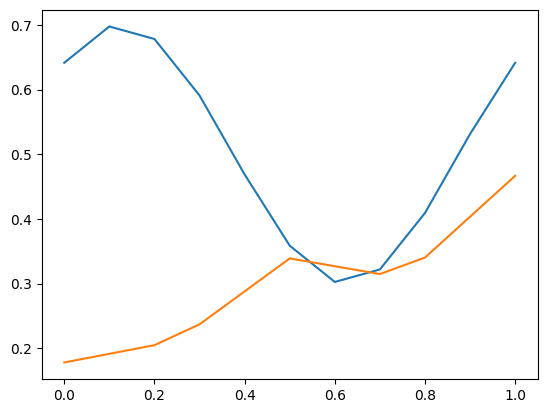

0.2


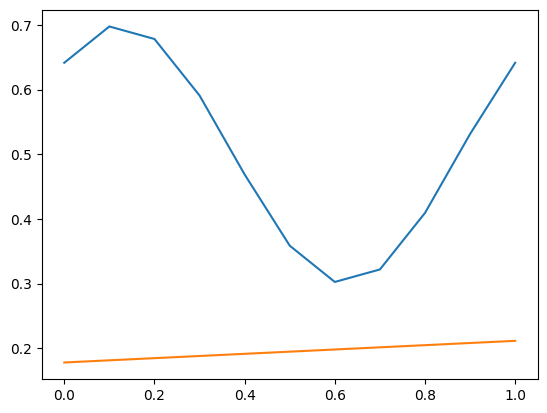

0.2


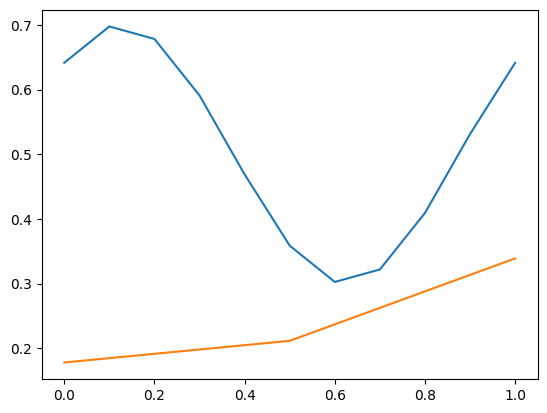

0.2


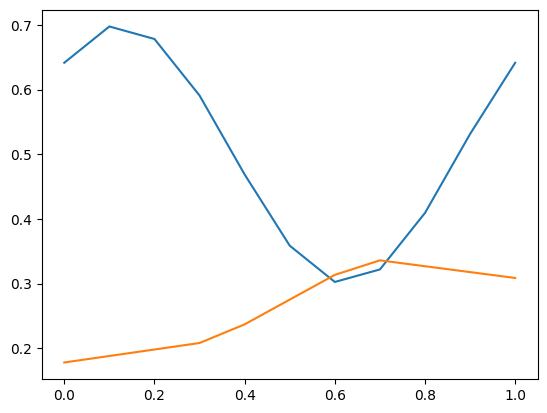

0.2


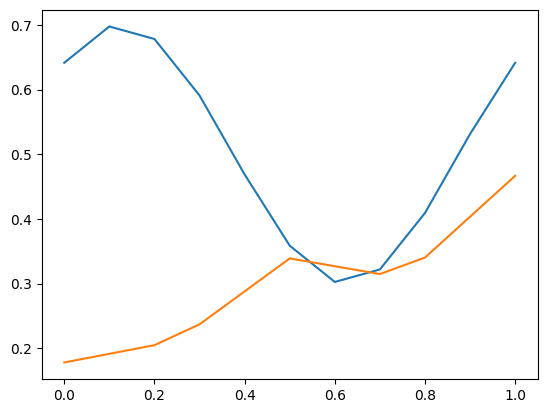

0.5


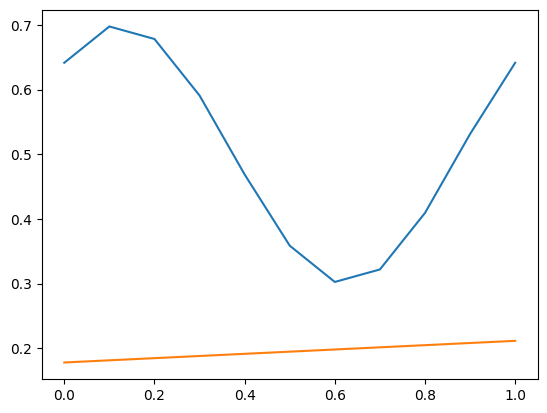

0.5


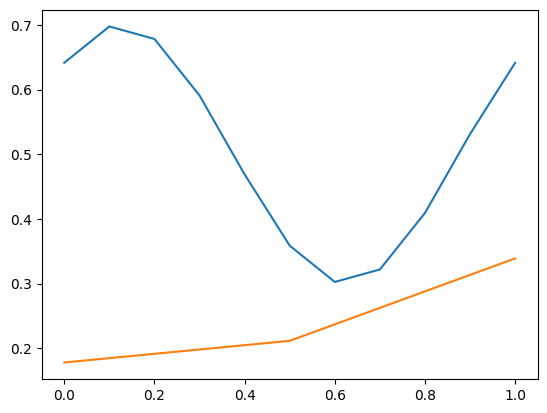

0.5


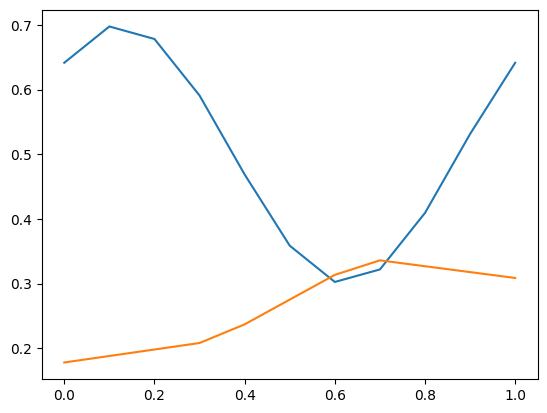

0.5


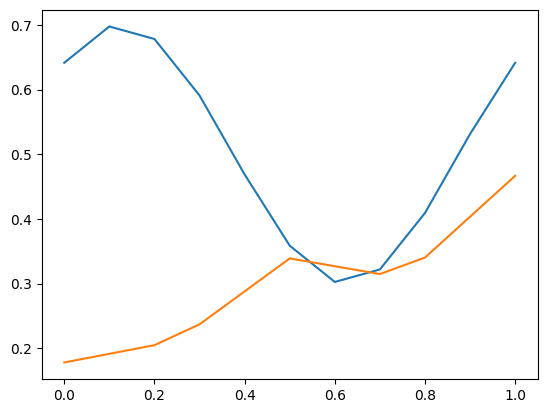

0.7


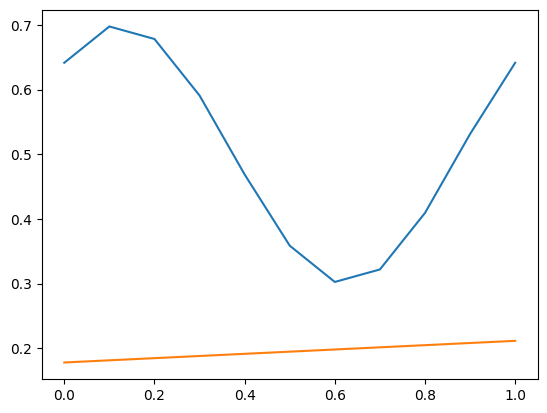

0.7


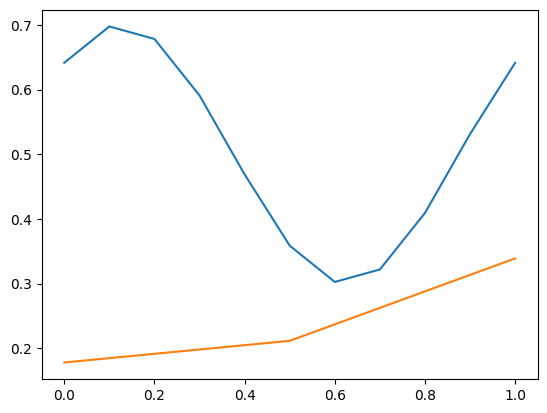

0.7


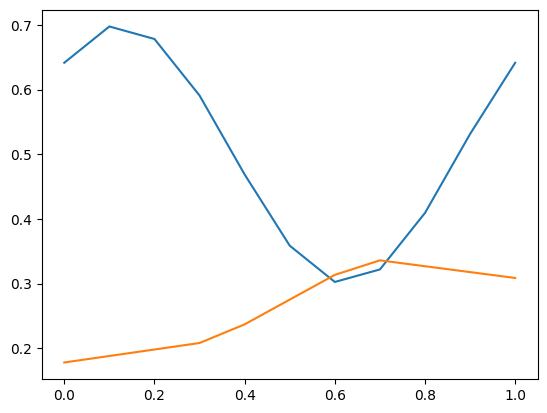

0.7


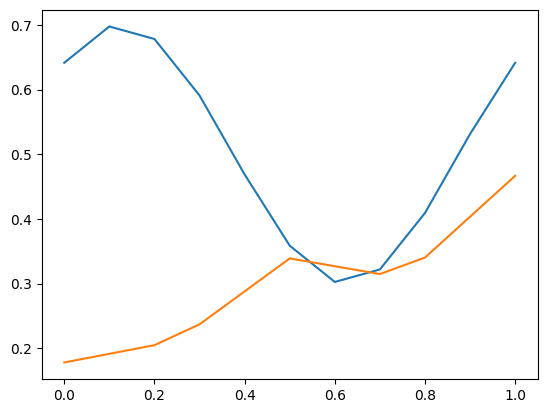

1


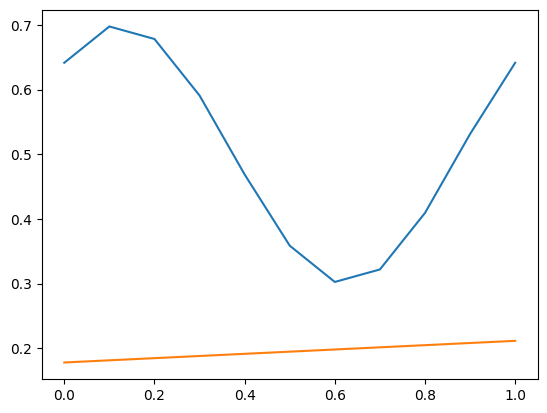

1


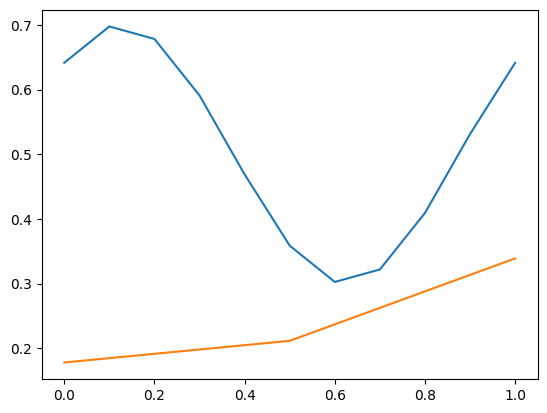

1


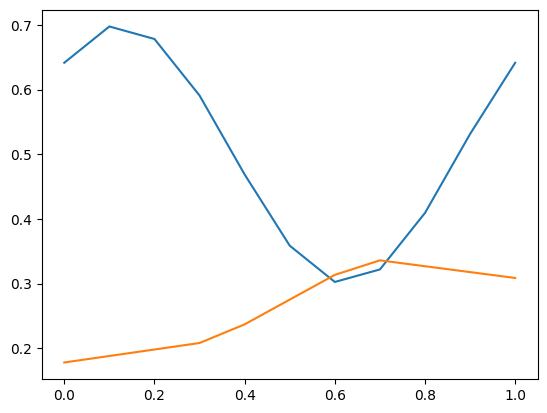

1


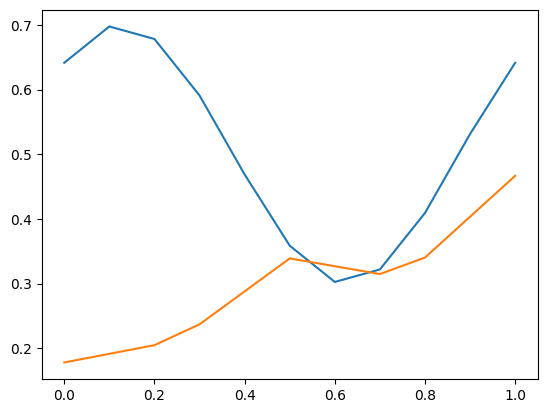

5


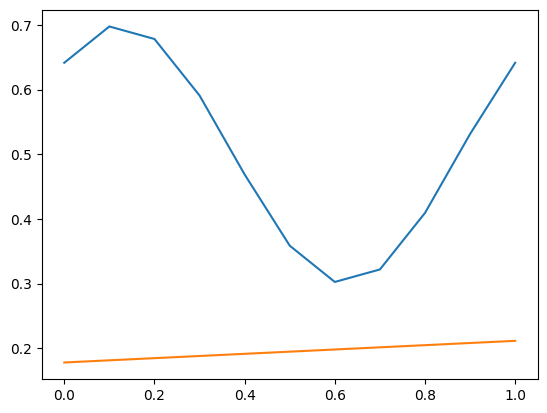

5


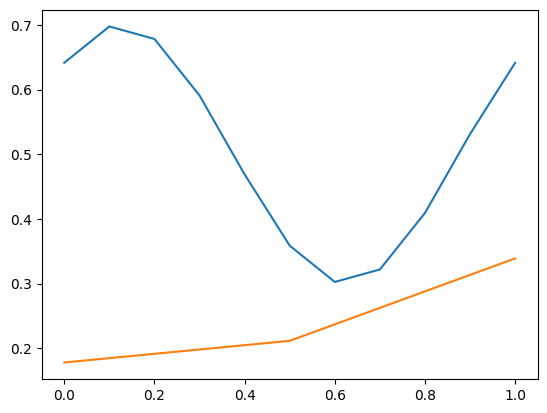

5


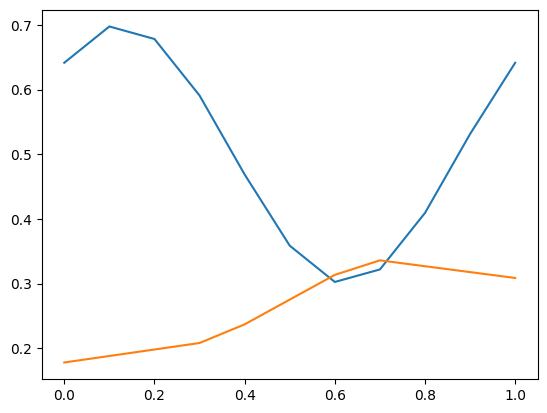

5


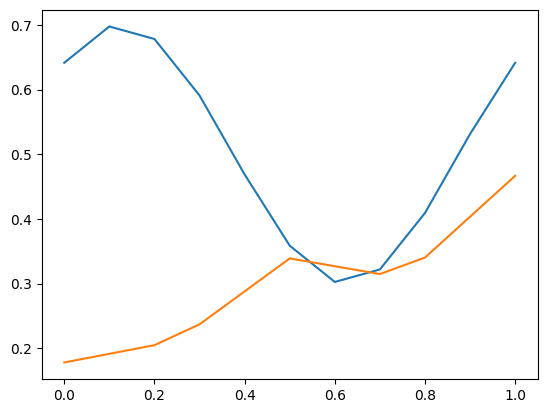

10


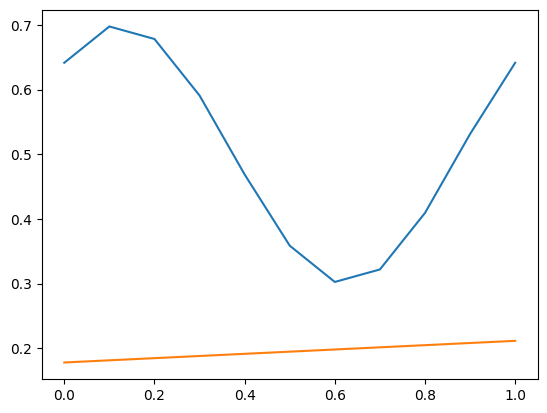

10


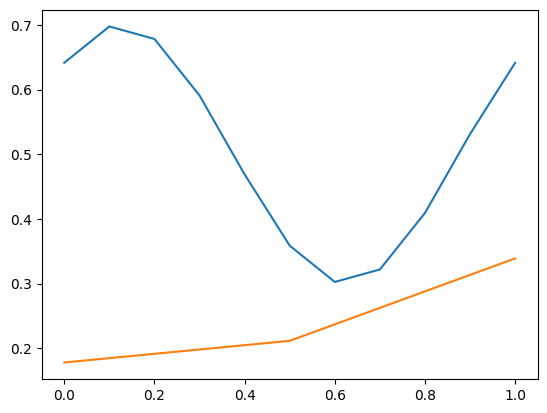

10


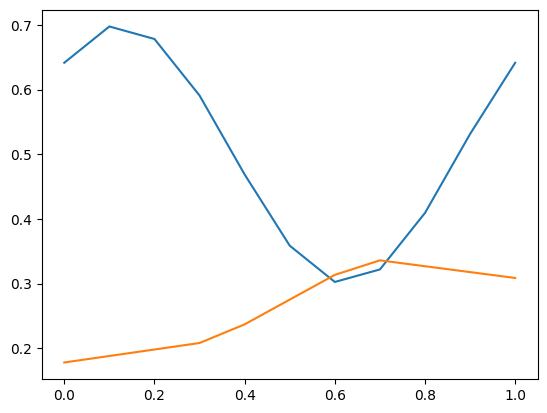

10


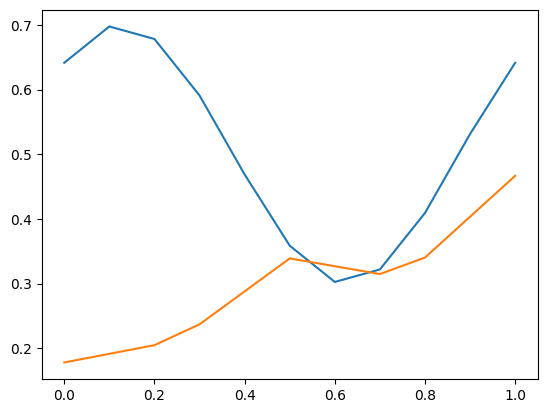

50


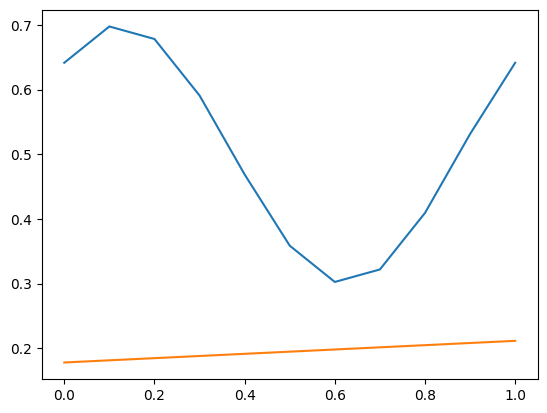

50


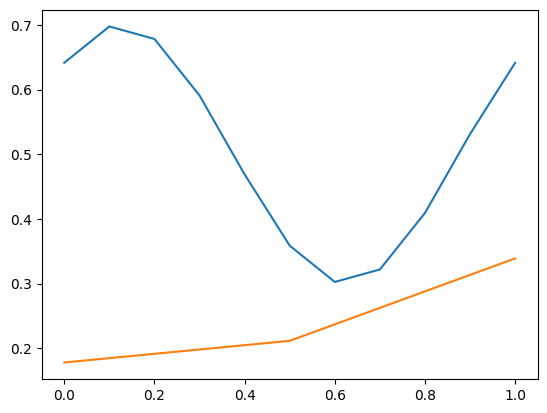

50


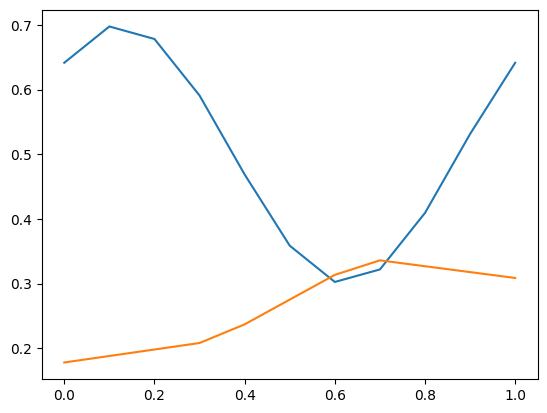

50


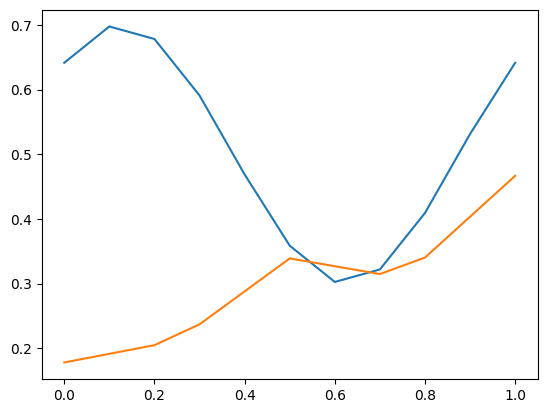

100


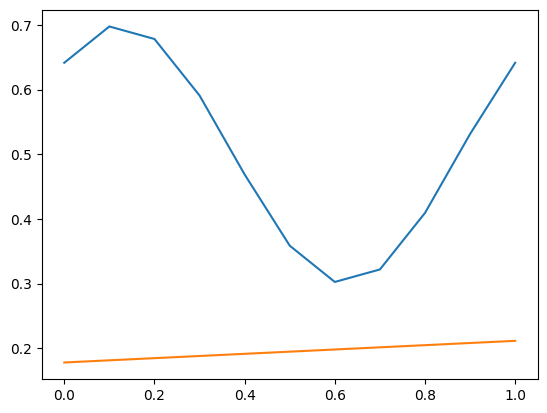

100


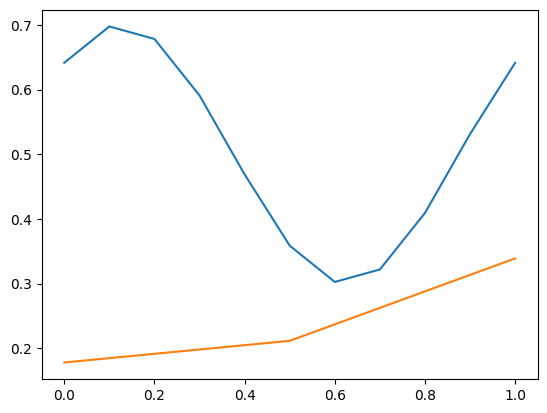

100


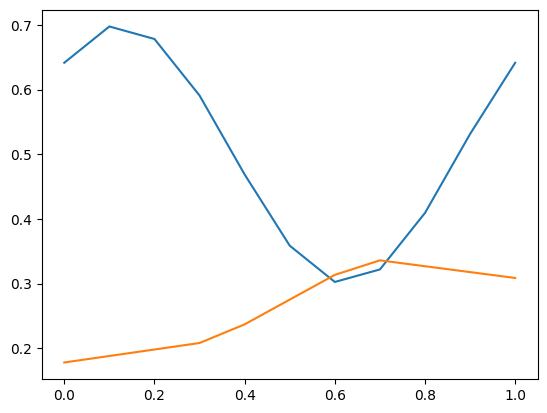

100


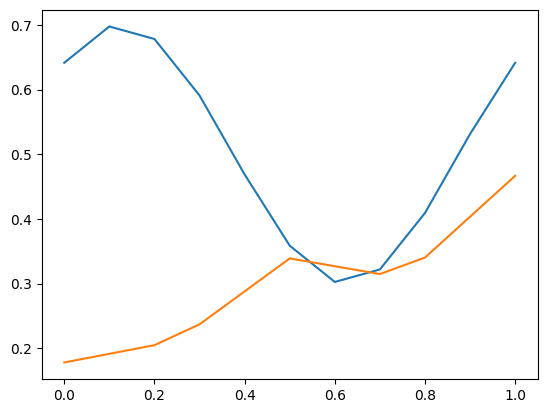

,alpha,K = 2,K = 3,K = 4,K = 5
0,0.1,0.673812,0.561051,0.537842,0.45295
1,0.2,0.673812,0.561051,0.537842,0.45295
2,0.5,0.673812,0.561051,0.537842,0.45295
3,0.7,0.673812,0.561051,0.537842,0.45295
4,1.0,0.673812,0.561051,0.537842,0.45295
5,5.0,0.673812,0.561051,0.537842,0.45295
6,10.0,0.673812,0.561051,0.537842,0.45295
7,50.0,0.673812,0.561051,0.537842,0.45295
8,100.0,0.673812,0.561051,0.537842,0.45295


In [68]:
# this is the function of equation (13) in the paper

#data = np.linspace(0.0, 1.0, num=3,dtype="float")
data = np.arange(0, 1.1, 0.1)

print(data)

def test(data): #equation 13
  output = []
  for x in data:
    output.append(0.2*math.sin(2*math.pi*x+math.pi/4) + 0.5)
  return np.array(output)

y=test(data)
x = np.array(data)

def execute(x,y,k,alpha):
  #membership_values=fuzz_membership(x,k)
  membership_values = membership_for_all_features(x,k)
  #print("Shape of membership values ->",np.array(membership_values).shape)


  # this will be the subspaces we will check on each value space
  combinations = combinations_for_k(k)
  dc = degree_of_compatibility(membership_values, combinations)
  #print("Shape of the degree of compatibility vector (samples, combinations) ->",np.array(dc).shape)

  w = Wj1_jn(dc,k,alpha)
  #print("Shape of W, should be same as dc ->",np.array(dc).shape)

  y_p = prediction(dc,b,w)

  PI = []
  for i in range(len(y)):
    a = (y_p[i]-y[i])**2
    PI.append(a/2)
    # print(f'predicted {y_p[i]} - real {y[i]}')
  PI=np.array(PI)
  #print("K = ",k," alpha = ",alpha," accuracy = ", np.sum(PI) )
  return np.sum(PI),y_p


ks= [[2],[3],[4],[5]]
alphas = [0.1,0.2,0.5,0.7,1,5,10,50,100]
  
general = []
for alpha in alphas:
  row = [alpha]
  for k in ks:
    a,out = execute(x,y,np.array(k),alpha)
    plt.plot(x,y,x,out)
    plt.show()
    row.append(a)
  general.append(row)

# Create the pandas DataFrame
df = pd.DataFrame(general, columns=['alpha', 'K = 2','K = 3','K = 4','K = 5'])
# print dataframe.
df




The more linguistic labels you have, the more precisse values will be outputed. So the IP will decrease with a higher number of labels.